Elapsed time: 0.03 seconds


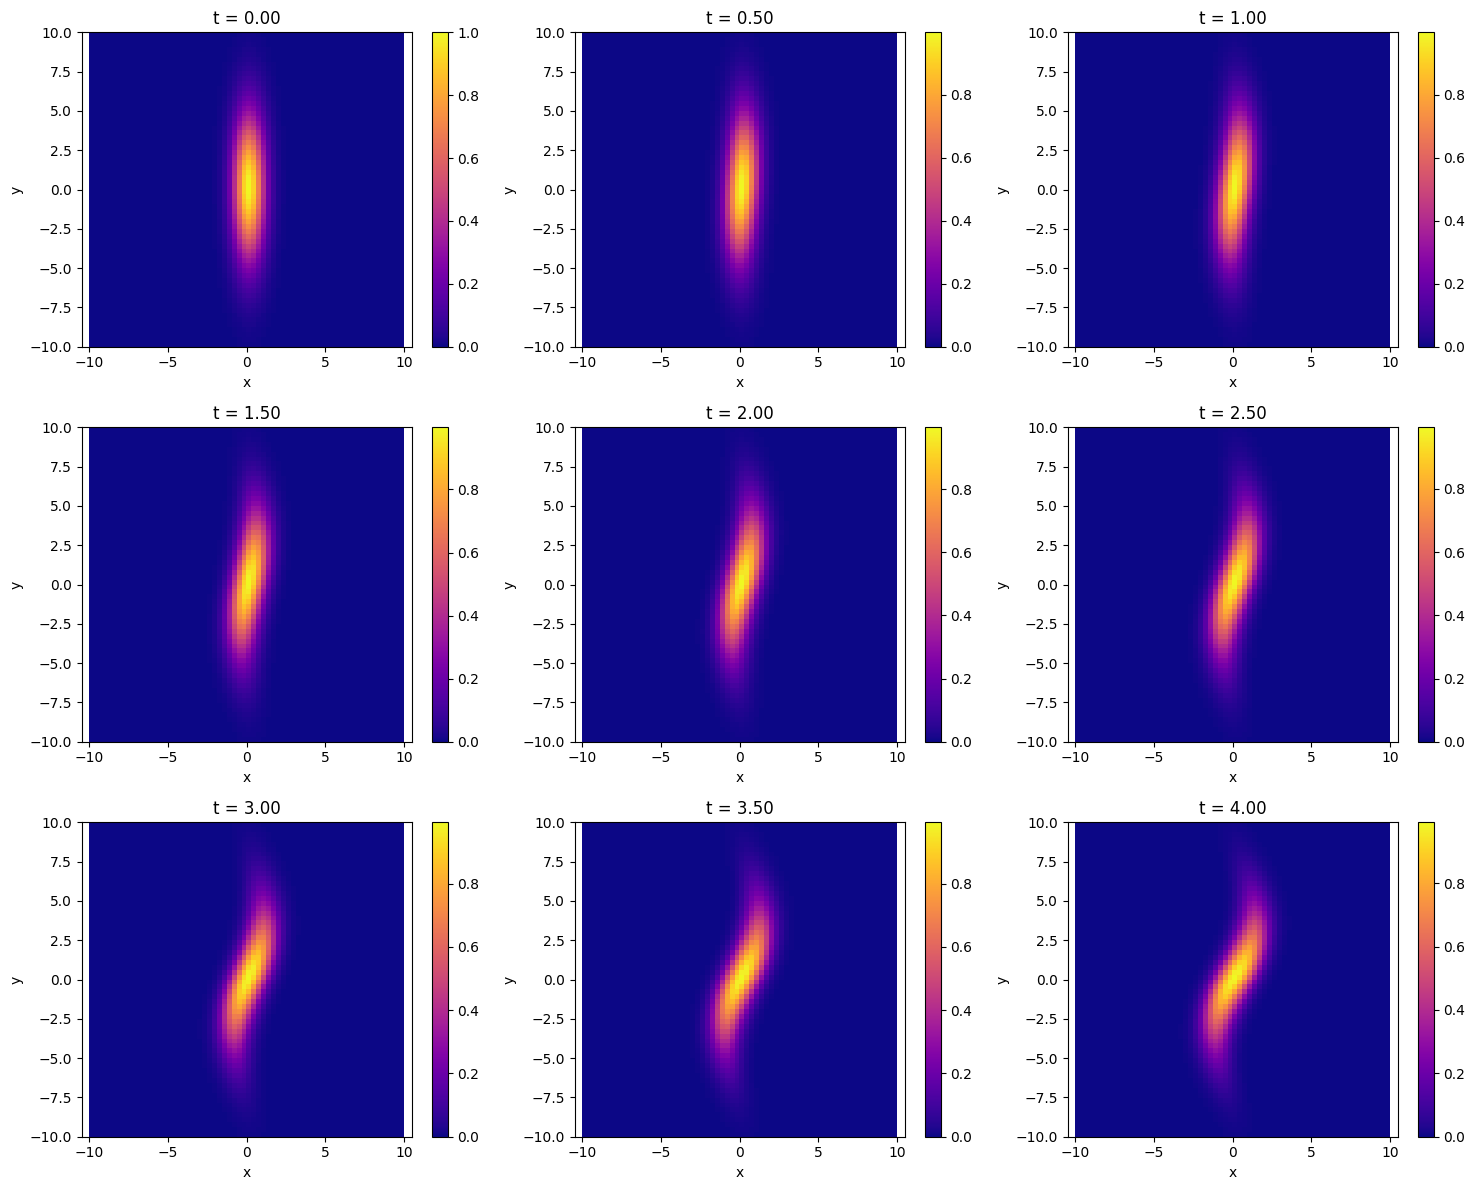

In [21]:
import numpy as np
from scipy.sparse import spdiags
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time 

m = 64 # N value in x and y directions
n = m * m # total size of matrix
L = 20
dx = dy = L / m

e0 = np.zeros((n, 1)) # vector of zeros
e1 = np.ones((n, 1)) # vector of ones
e2 = np.copy(e1) # copy the one vector
e4 = np.copy(e0) # copy the zero vector
for j in range(1, m+1):
    e2[m*j-1] = 0 # overwrite every m^th value with zero
    e4[m*j-1] = 1 # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]
e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]
# Place diagonal elements

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
e2.flatten(), -4 * e1.flatten(), e3.flatten(),
e4.flatten(), e1.flatten(), e1.flatten()]
offset = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]
matA = spdiags(diagonals, offset, n, n) / (dx**2)#.tocsc()
#matA[0,0] = 2 / (dx**2)

# Modify the first diagonal directly
#matA.data[0][0] = 2 / (dx**2)

A = matA#.tocsc()

e1 = np.ones((n, 1))  
e2 = np.ones((n, 1))  
e3 = np.ones((n,1))  
e4 = np.ones((n, 1 ))  


diagonals_B = [e1.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets_B = [-n+m, -m, m , n-m]  # Below and above neighbors (one step in y-direction)

matB = spdiags(diagonals_B, offsets_B, n, n) / ( 2 * dx )

B = matB

e1 = np.zeros((n, 1))  
e2 = np.ones((n, 1))  
e3 = np.copy(e2)  
e4 = np.copy(e1)  
for index in range(64):
    e1[64 * index]= 1
    e2[64 * index + 63] = 0
    e3[64 * index] = 0 
    e4[64 * index + 63]= 1


diagonals_C = [e1.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets_C = [-m+1, -1, 1 , m-1]  # Below and above neighbors (one step in y-direction)

matC = spdiags(diagonals_C, offsets_C, n, n) / ( 2 * dy)


C = matC

import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp

# Parameters
nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Initial vorticity (elliptical Gaussian)
w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape(N)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Poisson equation solver (in Fourier space)

start_time = time.time() # Record the start time

#def pde(nx, ny, K, N, B, C, A, nu, w2):
def pde(t, w2, nx, ny, A, B, C,  K , nu):
    w = w2.reshape(nx , ny)
    wt = fft2(w)
    psit = - wt / K 
    psi = np.real(ifft2(psit)).reshape(nx * ny)
    psi_x = B @ psi 
    psi_y = C @ psi
    wx = B @ w2
    wy = C @ w2
    rhs = nu * A @ w2 + (wx * psi_y) - (psi_x * wy)#.reshape(nx * ny)
    return rhs

wsol = solve_ivp(pde, [t[0], t[-1]], w2, t_eval=t , args = (nx, ny, A, B, C,  K , nu) , method = 'RK45')

A1 = wsol.y

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = A2[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Elapsed time: 1.03 seconds


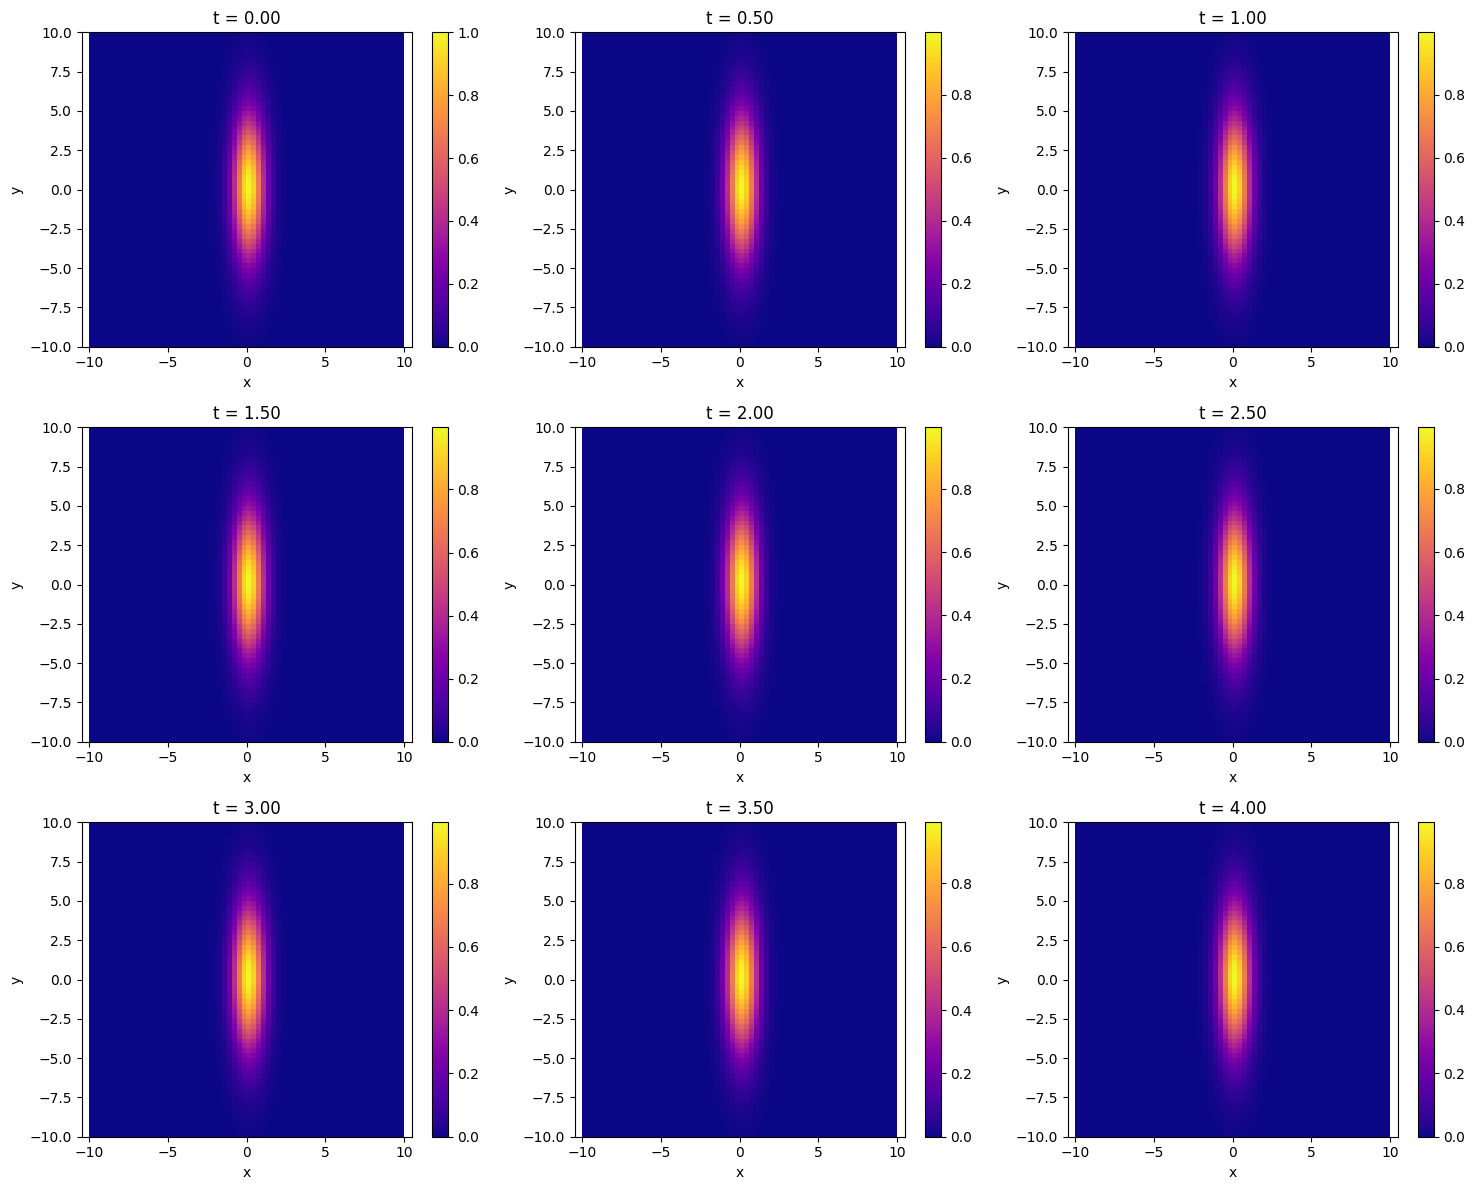

In [24]:
# A \ B


import numpy as np
from scipy.sparse import spdiags, diags
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import solve_ivp
import time

m = 64 # N value in x and y directions
n = m * m # total size of matrix
L = 20
dx = dy = L / m

e0 = np.zeros((n, 1)) # vector of zeros
e1 = np.ones((n, 1)) # vector of ones
e2 = np.copy(e1) # copy the one vector
e4 = np.copy(e0) # copy the zero vector
for j in range(1, m+1):
    e2[m*j-1] = 0 # overwrite every m^th value with zero
    e4[m*j-1] = 1 # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]
e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]
# Place diagonal elements

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
e2.flatten(), -4 * e1.flatten(), e3.flatten(),
e4.flatten(), e1.flatten(), e1.flatten()]
offset = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]
matA = spdiags(diagonals, offset, n, n) / (dx**2)#.tocsc()
#matA[0,0] = 2 / (dx**2)

# Modify the first diagonal directly
matA.data[0][0] = 2 / (dx**2)

A = matA#.tocsc()

nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape((N))

start_time = time.time() # Record the start time


def ab_rhs(t, w2, nx, ny, A, B, C,  nu):    
    #w2 = w.reshape(( nx, ny))
    psi = spsolve(A,w2)
    rhs = nu * A @ w2 + (B@ w2 * C@psi - B@psi * C@w2)
    return rhs#.toarray()
    
absol = solve_ivp(ab_rhs, [t[0], t[-1]], w2, t_eval=t , args = (nx, ny, A, B, C, nu) , method = 'RK45')

A2 = absol.y 

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = A2[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Elapsed time: 2.37 seconds


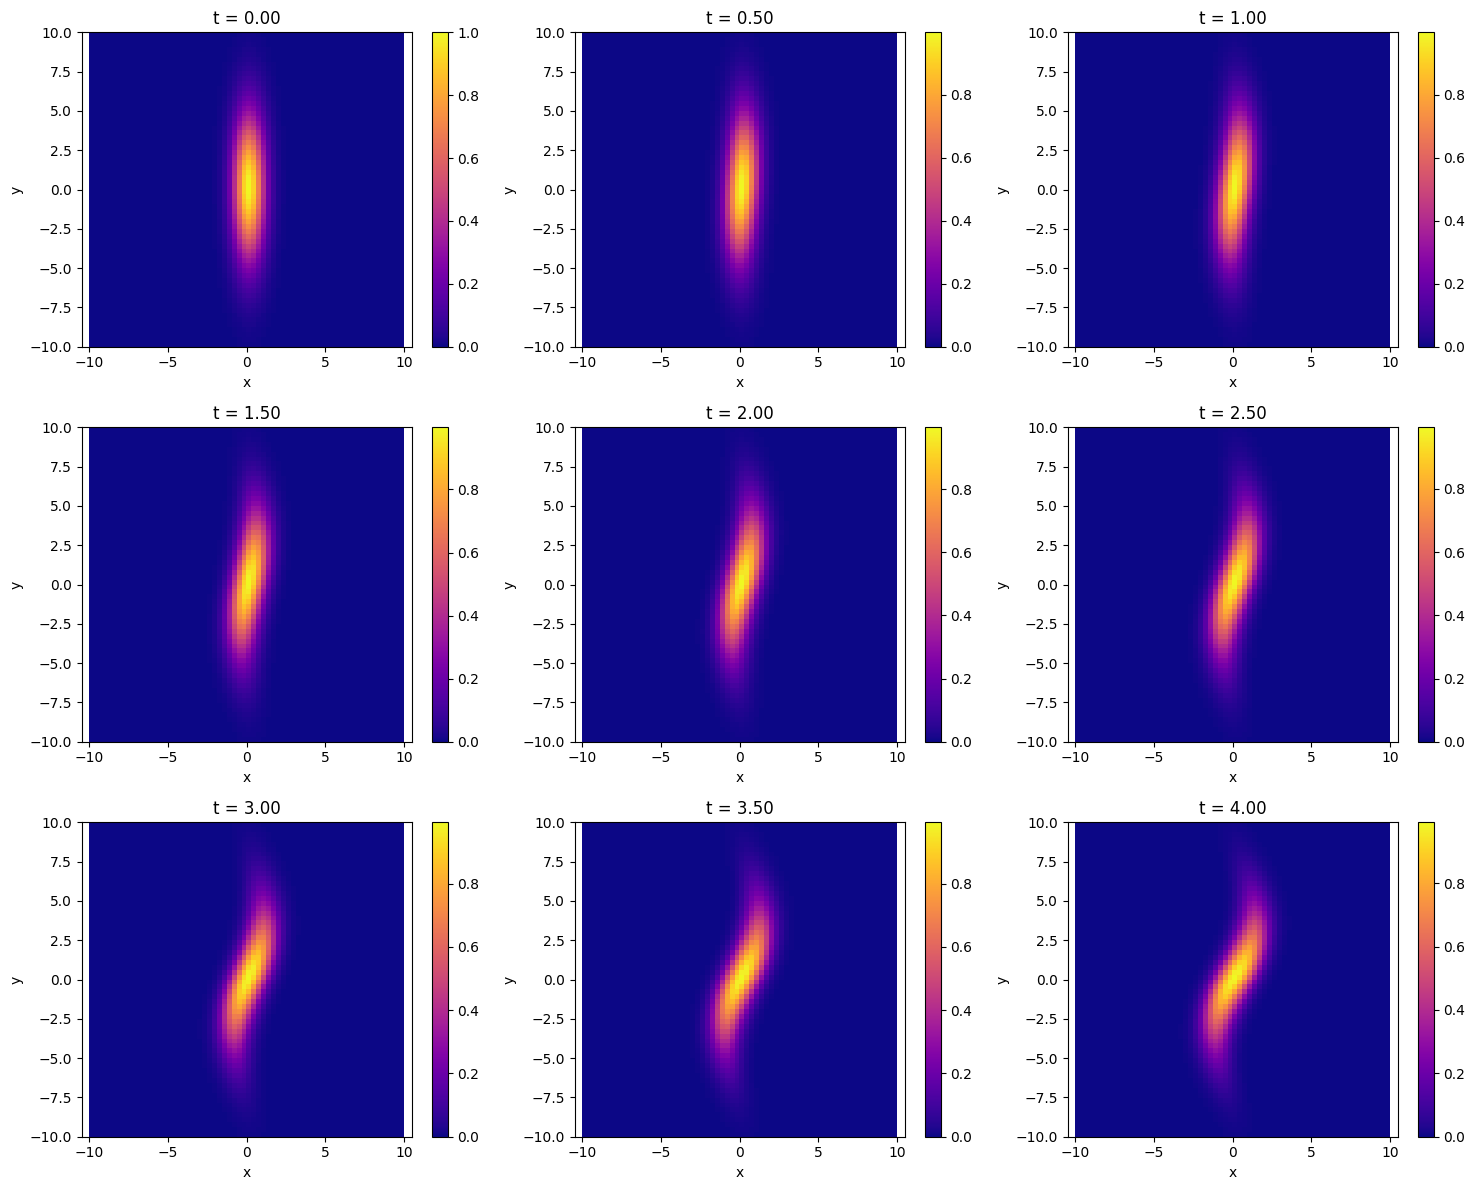

In [15]:
# Part b: LU Decomposition

import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
import time

nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape((N))

P, L, U = lu(A)

start_time = time.time() # Record the start time

def lu_rhs(t, w2, P, L, U, B, C, nu, A):
    #w2 = w.reshape(( nx, ny))
    Pb = np.dot(P, w2)
    #print( 'Tugglemynuts')
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    rhs = nu * np.dot(A, w2) + (np.dot(B, w2) * np.dot(C, psi)) - (np.dot(B, psi) * np.dot(C, w2))
    return rhs
    
lusol = solve_ivp(lu_rhs, [t[0], t[-1]], w2, t_eval=t , args = (P, L, U, B, C, nu, A) , method = 'RK45')

A3 = lusol.y 

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = A3[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Elapsed time: 120.14 seconds


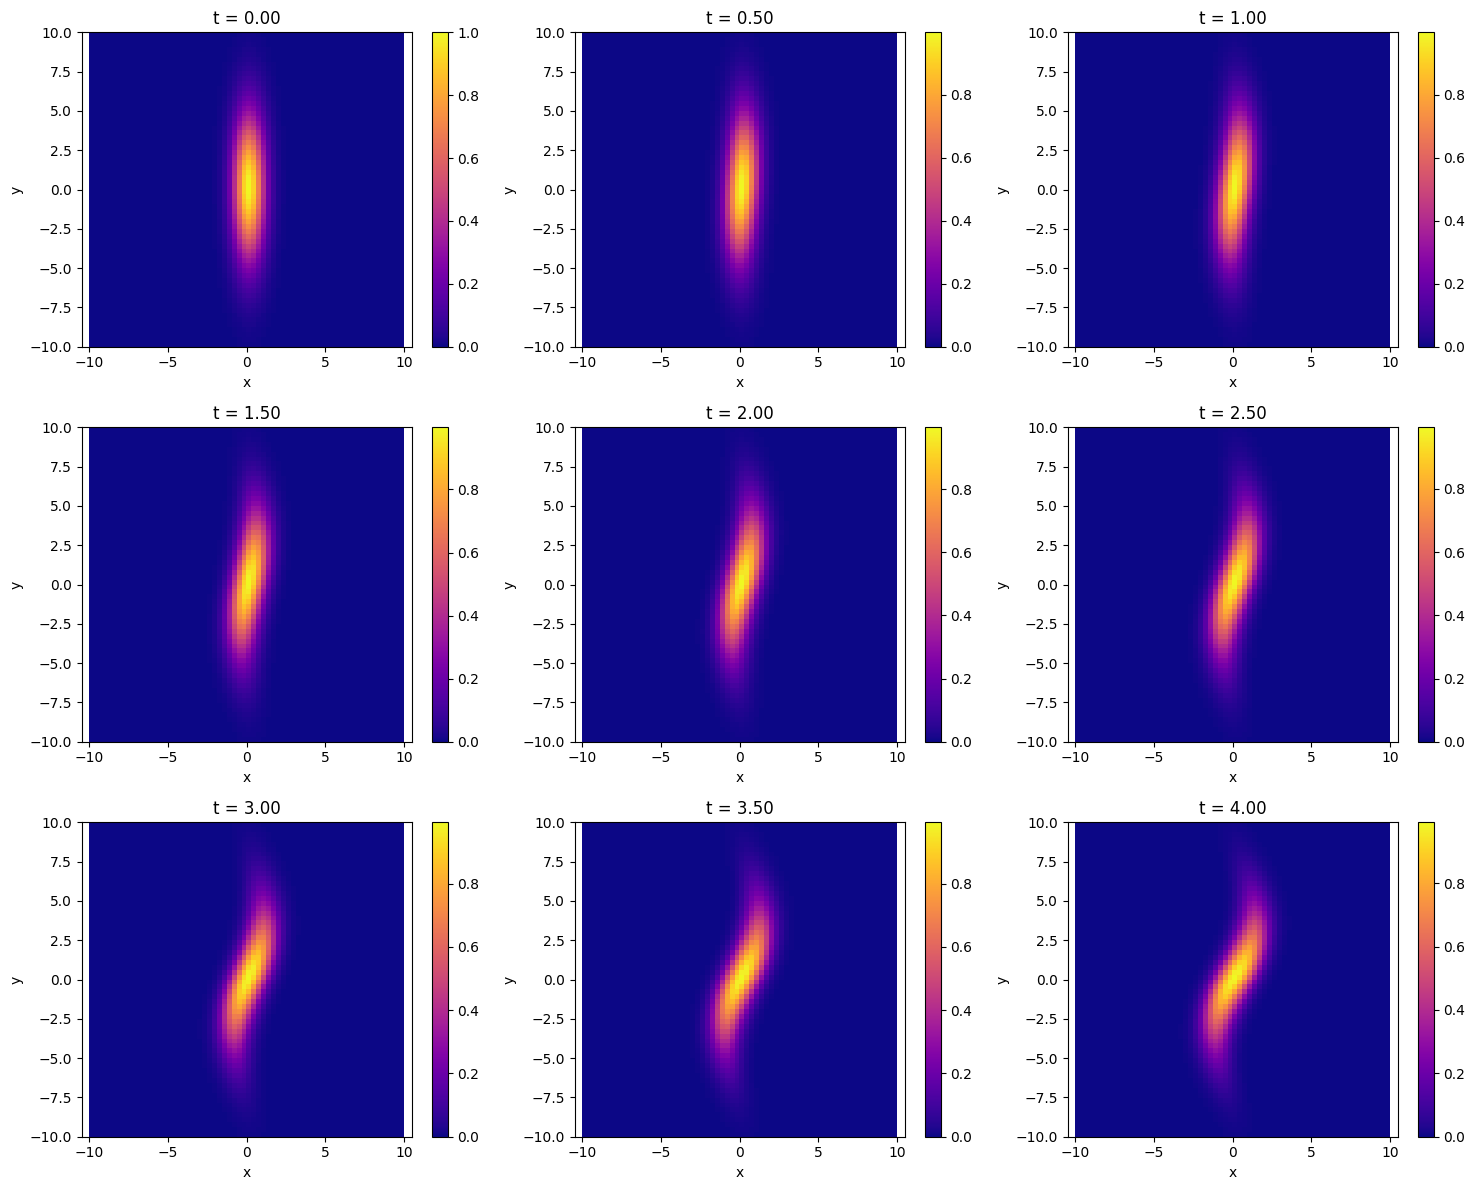

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import bicgstab  # Import BiCGSTAB solver
import scipy.sparse as sp

# Define parameters
nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # Time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Initial condition (vorticity field)
w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape((N))

# Assuming A, B, C are sparse matrices defined earlier in your code
# For example: 
# A = spdiags(...), B = spdiags(...), C = spdiags(...)

start_time = time.time()  # Record the start time

# Define the right-hand side function for the solver
def BS_rhs(t, w2, nx, ny, A, B, C, nu):    
    psi, _ = bicgstab(A, w2, tol=1e-6)  # Use BiCGSTAB to solve A * psi = w2
    rhs = nu * A.dot(w2) + B.dot(w2) * C.dot(psi) - B.dot(psi) * C.dot(w2)
    return rhs

# Solve the system using the Runge-Kutta method (RK45) with BiCGSTAB for the linear solve
BSsol = solve_ivp(BS_rhs, [t[0], t[-1]], w2, t_eval=t, args=(nx, ny, A, B, C, nu), method='RK45')

BS = BSsol.y  # The solution at each time step

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Plotting the results
intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = BS[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


Elapsed time: 14750.36 seconds


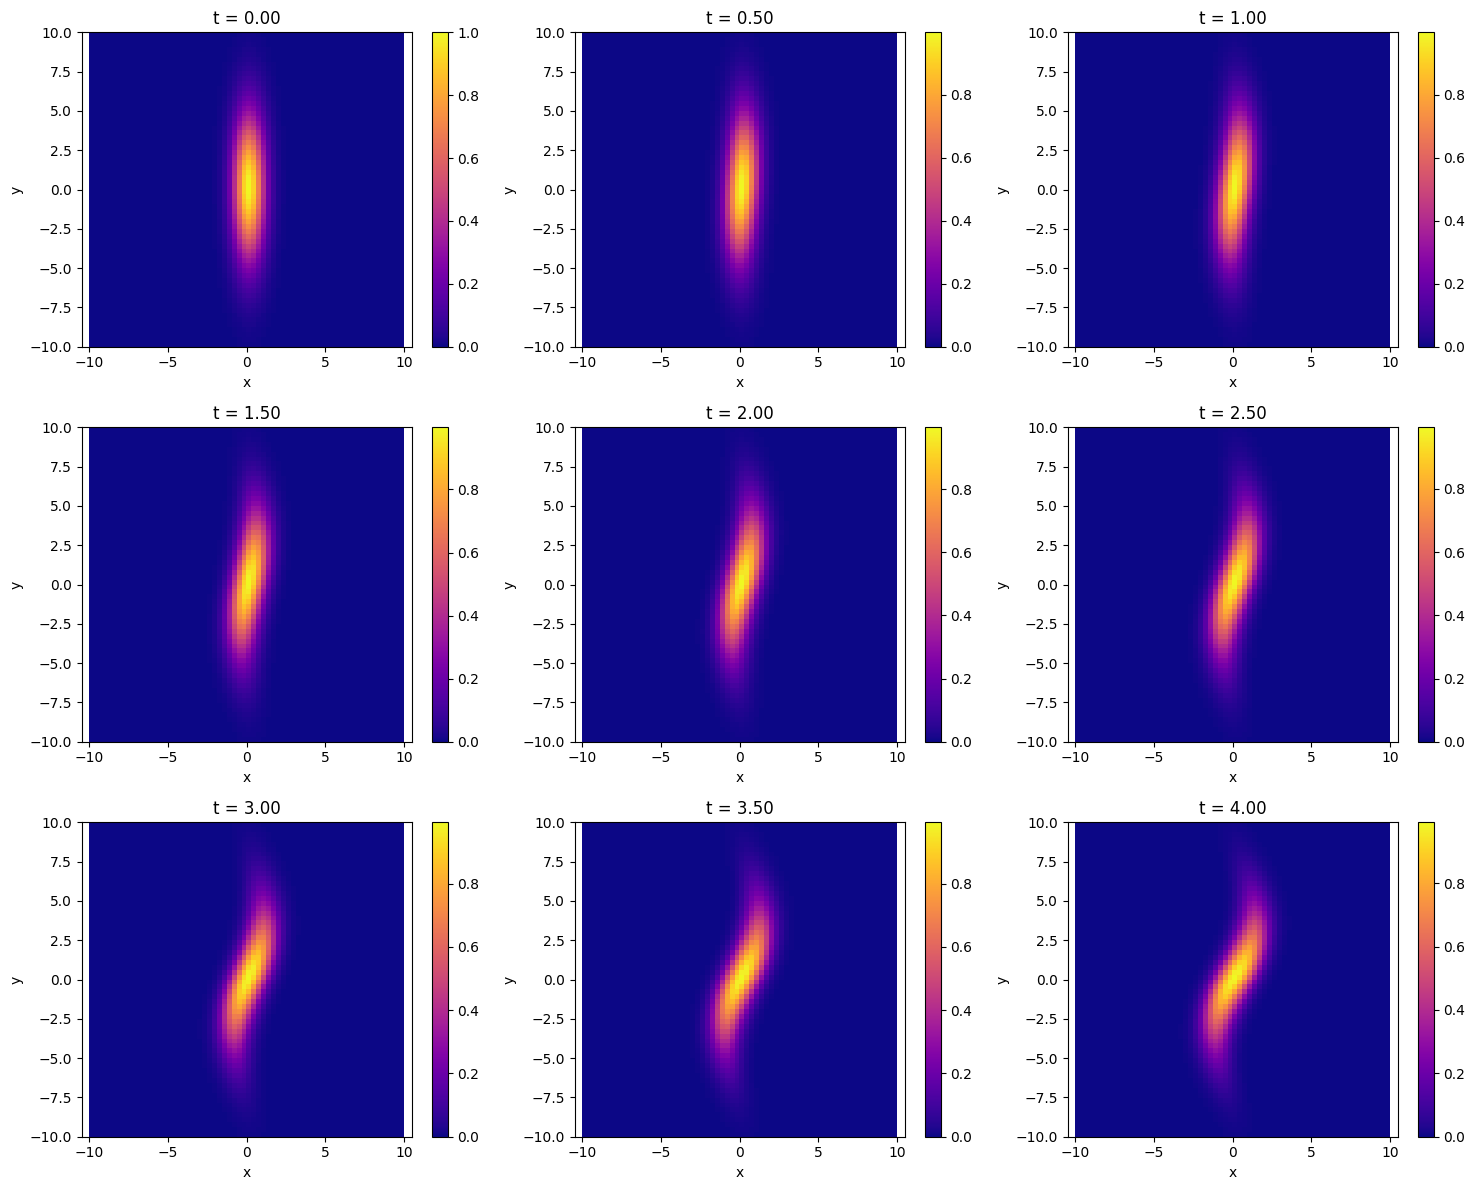

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import gmres  # Import GMRES solver
import scipy.sparse as sp

# Define parameters
nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # Time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Initial condition (vorticity field)
w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape((N))

# Assuming A, B, C are sparse matrices defined earlier in your code
# For example: 
# A = spdiags(...), B = spdiags(...), C = spdiags(...)

start_time = time.time()  # Record the start time

# Define the right-hand side function for the solver using GMRES
def GMRES_rhs(t, w2, nx, ny, A, B, C, nu):    
    # Use GMRES to solve A * psi = w2
    psi, _ = gmres(A, w2, tol=1e-6)  # GMRES to solve A * psi = w2
    rhs = nu * A.dot(w2) + B.dot(w2) * C.dot(psi) - B.dot(psi) * C.dot(w2)
    return rhs

# Solve the system using the Runge-Kutta method (RK45) with GMRES for the linear solve
GMRESsol = solve_ivp(GMRES_rhs, [t[0], t[-1]], w2, t_eval=t, args=(nx, ny, A, B, C, nu), method='RK45')

GMRES = GMRESsol.y  # The solution at each time step

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Plotting the results
intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = BS[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


Elapsed time: 0.77 seconds


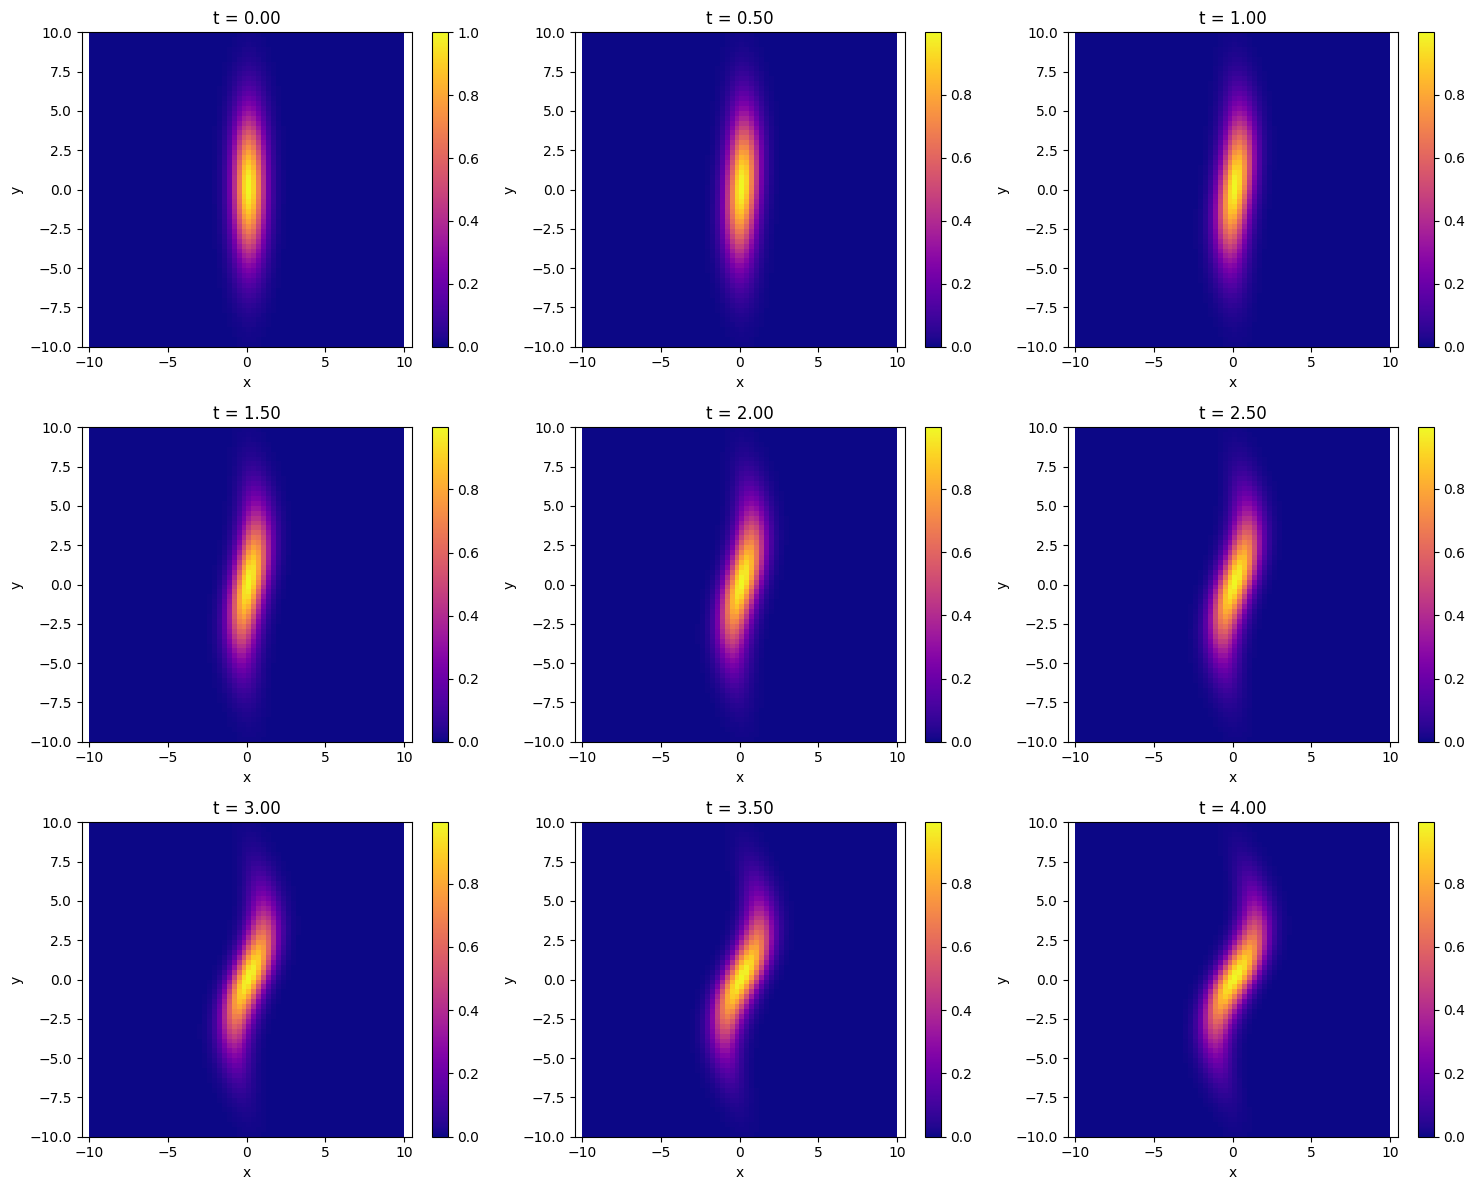

In [25]:
#BiCGSTAB


import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import bicgstab  # Import BiCGSTAB solver
import scipy.sparse as sp

# Define parameters
nu = 0.001
Lx = 20
Ly = 20
nx = 64
ny = 64
N = nx * ny
t = np.arange(0, 4.5, 0.5)  # Time array

# Create the spatial grid
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Initial condition (vorticity field)
w = np.exp( - X ** 2 - (1/20) * (Y**2))
w2 = w.reshape((N))

# Assuming A, B, C are sparse matrices defined earlier in your code
# For example: 
# A = spdiags(...), B = spdiags(...), C = spdiags(...)

start_time = time.time()  # Record the start time

# Define the right-hand side function for the solver
def BS_rhs(t, w2, nx, ny, A, B, C, nu):
    Bw2 = B.dot(w2)
    Cw2 = C.dot(w2)
    psi, _ = bicgstab(A, w2, tol=1e-4)  # Use BiCGSTAB to solve A * psi = w2
    rhs = nu * A.dot(w2) + Bw2 * C.dot(psi) - B.dot(psi) * Cw2
    return rhs

# Solve the system using the Runge-Kutta method (RK45) with BiCGSTAB for the linear solve
BSsol = solve_ivp(BS_rhs, [t[0], t[-1]], w2, t_eval=t, args=(nx, ny, A, B, C, nu), method='RK45')

BS = BSsol.y  # The solution at each time step

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Plotting the results
intervals = np.linspace(0, len(t) - 1, 9, dtype=int)

# Create a 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# Loop through each selected time step and plot the vorticity
for i, idx in enumerate(intervals):
    w = BS[:, idx].reshape(nx, ny)  # Reshape solution at the current time step to (64, 64)
    
    # Plot the vorticity field as a grayscale image
    im = axs[i].imshow(w, cmap='plasma', origin='lower', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    axs[i].set_title(f"t = {t[idx]:.2f}")
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
    # Add a color bar to each subplot
    fig.colorbar(im, ax=axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()
